In [1]:
from htm.algorithms import TemporalMemory
from htm_rl.modules.htm.temporal_memory import DelayedFeedbackTM
from htm.bindings.sdr import SDR
import numpy as np
import matplotlib.pyplot as plt
from htm_rl.modules.htm.spatial_pooler import UnionTemporalPooler
import seaborn as sns

In [2]:
from configs import *  # I'm so sorry for this...

tm = DelayedFeedbackTM(**config_tm)
tp = UnionTemporalPooler(**config_tp)


def make_sdr(pos: tuple, _shape: tuple) -> SDR:
    result = SDR(_shape)
    numpy_res = result.dense
    numpy_res = np.zeros(_shape)
    numpy_res[pos] = 1
    result.dense = numpy_res
    return result


def make_sdrs(array: np.ndarray, _shape: tuple) -> np.ndarray:
    result = np.ndarray((array.size,), dtype=SDR)
    iterator = 0
    for number in array:
        result[iterator] = make_sdr(number, _shape)
        iterator += 1
    return result


def learn_model(tm: TemporalMemory, sdrs: np.ndarray, num_epochs=10) -> list:
    errors = []
    for epoch in range(num_epochs):
        for sdr in sdrs:
            tm.compute(sdr, learn=True)
            tm.activateDendrites(True)
            errors.append(tm.anomaly)
        tm.compute(SDR(sdrs[0].dense.shape), learn=False)
    return errors


def generate_data(n, n_actions, n_states, randomness=1.0, seed=0):
    raw_data = list()
    np.random.seed(seed)
    seed_seq = np.random.randint(0, n_actions, n_states)
    raw_data.append(seed_seq.copy())
    n_replace = int(n_states * randomness)
    for i in range(1, n):
        new_seq = np.random.randint(0, n_actions, n_states)
        if randomness == 1.0:
            raw_data.append(new_seq)
        else:
            indices = np.random.randint(0, n_states, n_replace)
            seed_seq[indices] = new_seq[indices]
            raw_data.append(seed_seq.copy())
    data = [list(zip(range(n_states), x)) for x in raw_data]
    return raw_data, data


def compute(tm, state, action, learn=True):
    context = state_encoder.encode(state)
    active_input = action_encoder.encode(action)

    tm.set_active_context_cells(context)

    tm.activate_basal_dendrites(learn)
    tm.predict_cells()

    tm.set_active_columns(active_input)
    tm.activate_cells(learn)


tp_prev_union = SDR(tp.getNumColumns())


def run(tm, tp, policy, state_encoder, action_encoder, learn=True):
    tp_input = SDR(tp.getNumInputs())
    tp_predictive = SDR(tp.getNumInputs())
    tp_errors = []
    window_size = 25
    window_error = 0
    counter = 0
    for state, action in policy:
        context = state_encoder.encode(state)
        active_input = action_encoder.encode(action)

        tm.set_active_context_cells(context)

        tm.activate_basal_dendrites(learn)

        tm.set_active_feedback_cells(tp.getUnionSDR().sparse)
        tm.activate_apical_dendrites(learn)
        tm.propagate_feedback()

        tm.predict_cells()

        tm.set_active_columns(active_input)
        tm.activate_cells(learn)

        tp_input.sparse = tm.get_active_cells()
        tp_predictive.sparse = tm.get_correctly_predicted_cells()
        tp.compute(tp_input, tp_predictive, learn)

        apical_predict = tm.predictive_cells_apical
        active_cells = tm.get_active_cells()

        ###
        intersect = np.intersect1d(apical_predict, active_cells)
        union = np.union1d(apical_predict, active_cells)
        window_error += (union.size - intersect.size) / union.size

        current_union = tp.getUnionSDR().sparse.copy()

        if counter % window_size == window_size - 1:
            tp_errors.append(window_error / window_size)
        tp_prev_union.sparse = current_union

        counter += 1

    return tp_errors


row_data, data = generate_data(4, n_actions, n_states)
errors = []
for i in range(100):
    errors.extend(run(tm, tp, data[0], state_encoder, action_encoder, True))
# print(errors)

In [9]:

# print(f'row: {row_data[:1]}\n')
# print(f'data: {data[:1]}\n')

In [8]:
tm = DelayedFeedbackTM(**config_tm)
tp = UnionTemporalPooler(**config_tp)
errors = run(tm, tp, data[0], state_encoder, action_encoder)
# print(data)
# print(errors)

Text(0.5, 1.0, 'tp_one_policy_errors')

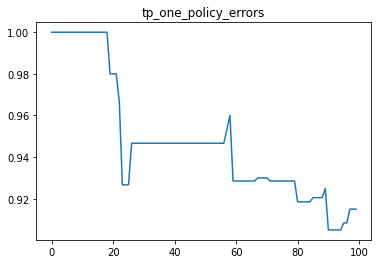

In [11]:
plt.plot(range(len(errors)), errors)
plt.title('tp_one_policy_errors')

In [43]:
from configs import *
class MyUTP:
    _initial_pooling = 1
    _pooling_decay = 0.1

    def __init__(self, **utp_config):
        input_shape = utp_config['inputDimensions']
        output_shape = utp_config['columnDimensions']
        out_size = np.prod(output_shape)
        in_size = np.prod(input_shape)
        self._union_sdr = SDR(output_shape)
        self._pooling_activations = np.zeros(output_shape)
        self._shape = output_shape
        self._initial_pooling = utp_config['initial_pooling']
        self._pooling_decay = utp_config['pooling_decay']
        self._permanence_inc = utp_config['permanence_inc']
        self._permanence_dec = utp_config['permanence_dec']
        self.winners_num = int(np.ceil(utp_config['sparsity']*out_size))

        self.connections = np.zeros((out_size, in_size), dtype=float)


    def pooling_decay_step(self):
        self._pooling_activations[self._pooling_activations != 0] -= self._pooling_decay
        self._pooling_activations = self._pooling_activations.clip(0, float('inf'))

    def get_active_cells(self, data: np.ndarray) -> SDR:
        tie_breaker = np.random.normal(0, 0.01, self._shape)
        activations = self.connections @ data + tie_breaker

        most_active = np.argpartition(activations.flatten(), -self.winners_num)[-self.winners_num:]
        result_sdr = SDR(self._shape)
        result_sdr.sparse = most_active
        return result_sdr

    def update_permanences(self, data: np.ndarray):
        self.connections[:, np.flatnonzero(data)] -= self._permanence_dec

        active_synapses = np.ix_(self._union_sdr.sparse, np.flatnonzero(data))
        self.connections[active_synapses] += self._permanence_inc + self._permanence_dec

        self.connections = self.connections.clip(0, 1)

    def compute(self, data: np.ndarray, learn: bool = True):
        winners = self.get_active_cells(data)
        self.pooling_decay_step()
        self._pooling_activations[winners.sparse] += self._initial_pooling
        self._union_sdr.dense = self._pooling_activations != 0

        if learn:
            self.update_permanences(data)

def get_data(num):
    data = np.zeros(4)
    data[num] = 1
    return data
# input_columns = 4
# cells_per_column = 4
utp_conf = {
    'inputDimensions': 4,
    'columnDimensions': [input_columns * cells_per_column],
    'initial_pooling': 1,
    'pooling_decay': 0.1,
    'permanence_inc': 0.2,
    'permanence_dec': 0.1,
    'sparsity': 0.04
}
np.random.seed(42)
tp_shape = utp_conf['columnDimensions']
in_shape = utp_conf['inputDimensions']
my_utp = MyUTP(**utp_conf)
for epoch in range(3):
    for i in range(4):
        my_utp.compute(get_data(i))
print(my_utp.connections[my_utp.connections == 0.1])

[]


<AxesSubplot:>

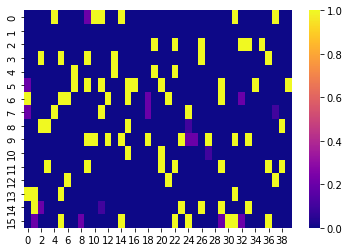

In [44]:
sns.heatmap(my_utp._pooling_activations.reshape(-1, input_columns),vmin=0, vmax=1, cmap='plasma')